# Project 1

## 2. Exploration of the attributes

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [78]:
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import seaborn as sns  

--- 

Loading the dataframe

In [79]:
df = pd.read_csv('/Users/armandomijares/Desktop/ML/data/glass.data', header=None)

# Name columns
df = df.rename(columns={0: 'Id', 1: 'RI', 2: 'Na', 3: 'Mg', 4: 'Al', 5: 'Si', 6: 'K', 7: 'Ca', 8: 'Ba', 9: 'Fe', 10: 'Type'})
# Change type of 'Type' to categorical
df['Type'] = df['Type'].astype('category')
# df['Type'] = df['Type'].cat.rename_categories({ 1: 'building_windows_float_processed',
#                                                 2: 'building_windows_non_float_processed',
#                                                 3: 'vehicle_windows_float_processed',
#                                                 4: 'vehicle_windows_non_float_processed',
#                                                 5: 'containers',
#                                                 6: 'tableware',
#                                                 7: 'headlamps'})
df['Type'] = df['Type'].cat.rename_categories({ 1: 'BW-FP',
                                                2: 'BW-NFP',
                                                3: 'VW-FP',
                                                4: 'VW-NFP',
                                                5: 'containers',
                                                6: 'tableware',
                                                7: 'headlamps'})

# Numerical variables
X = df.drop(columns=['Id', 'Type'])     # dataframe
Xe = X.drop(columns=['RI'])             # only chemical elements

X_np = X.to_numpy()                     # numpy array

# Standardize data
Xc = (X - X.mean(axis=0))               # Centering
Xs = Xc / Xc.std(axis=0, ddof=1)        # Standardization with unbiased estimator (N-1 in denominator)
Xec = (Xe - Xe.mean(axis=0))            # Centering
Xes = Xec / Xec.std(axis=0, ddof=1)     # Standardization with unbiased estimator (N-1 in denominator)

# Categorical variable
y = df['Type']          # dataframe   
y_np = y.to_numpy()     # numpy array  
label_encoder = LabelEncoder()
y_num = label_encoder.fit_transform(y)

print(df.head())

   Id       RI     Na    Mg    Al     Si     K    Ca   Ba   Fe   Type
0   1  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0  BW-FP
1   2  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0  BW-FP
2   3  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0  BW-FP
3   4  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0  BW-FP
4   5  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0  BW-FP


---

Missing values? -> *No missing values*  

In [80]:
df.isna().sum()

Id      0
RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

---

## Summary statistics

In [81]:
# Basic statistics about the numerical variables
#print(X.describe())

# Compute summary statistics for selected key attributes
summary = X.describe().T  # transpose for nicer table format
summary["missing_%"] = (X.isna().sum() / len(X)) * 100

# Round for readability
summary = summary[["mean", "std", "min", "max", "missing_%"]].round(3)

summary.head(10)  # show first 10 attributes

# Distribution of the target variable (see visualizations below)
#print(y.value_counts())

,mean,std,min,max,missing_%
RI,1.518,0.003,1.511,1.534,0.0
Na,13.408,0.817,10.730,17.380,0.0
Mg,2.685,1.442,0.000,4.490,0.0
Al,1.445,0.499,0.290,3.500,0.0
Si,72.651,0.775,69.810,75.410,0.0
K,0.497,0.652,0.000,6.210,0.0
Ca,8.957,1.423,5.430,16.190,0.0
Ba,0.175,0.497,0.000,3.150,0.0
Fe,0.057,0.097,0.000,0.510,0.0


Summary stats (with skewness & kurtosis):


,mean,std,min,max,skew,kurtosis,missing_%
RI,1.518,0.003,1.511,1.534,1.625,4.932,0.0
Na,13.408,0.817,10.730,17.380,0.454,3.052,0.0
Mg,2.685,1.442,0.000,4.490,-1.153,-0.410,0.0
Al,1.445,0.499,0.290,3.500,0.907,2.061,0.0
Si,72.651,0.775,69.810,75.410,-0.730,2.968,0.0
K,0.497,0.652,0.000,6.210,6.552,54.690,0.0
Ca,8.957,1.423,5.430,16.190,2.047,6.682,0.0
Ba,0.175,0.497,0.000,3.150,3.416,12.541,0.0
Fe,0.057,0.097,0.000,0.510,1.754,2.662,0.0


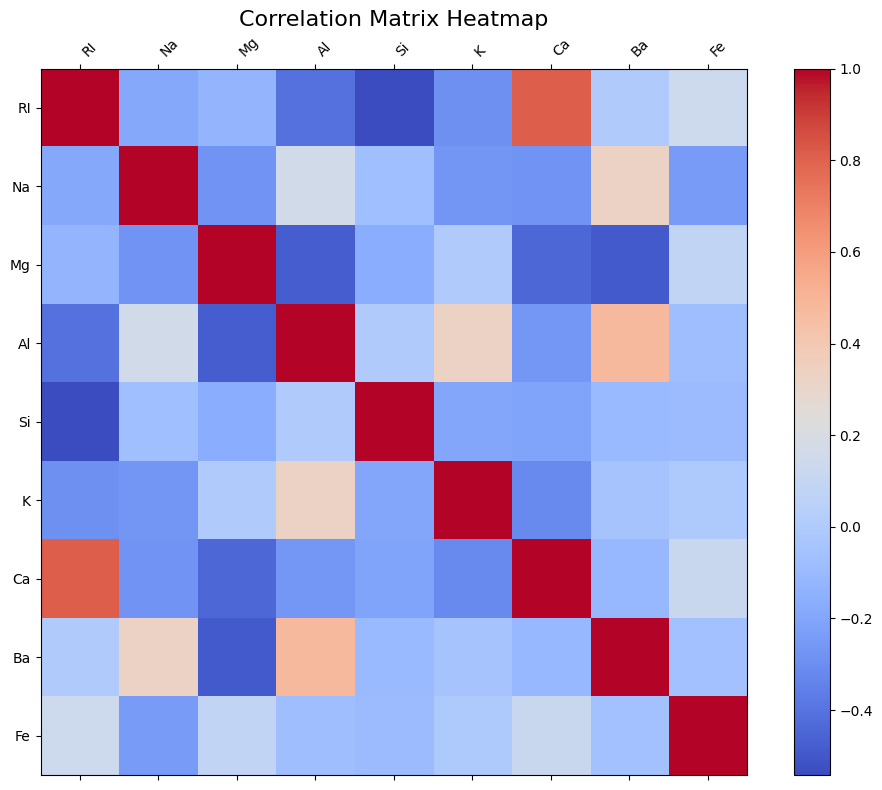

In [82]:
# corrected correlation heatmap and extra summary stats 
# added skewness / kurtosis to the summary table so I can write about shape

summary = X.describe().T
summary['skew'] = X.skew().round(3)
summary['kurtosis'] = X.kurtosis().round(3)
summary['missing_%'] = (X.isna().sum() / len(X)) * 100
summary = summary[['mean', 'std', 'min', 'max', 'skew', 'kurtosis', 'missing_%']].round(3)
print("Summary stats (with skewness & kurtosis):")
display(summary)

# Correct correlation heatmap (fix: X_df -> X)
corr_matrix = X.corr()
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr_matrix, cmap='coolwarm')
fig.colorbar(cax)
ticks = np.arange(0, len(X.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns, rotation=45, ha='left')
ax.set_yticklabels(X.columns)
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.tight_layout()
#plt.savefig("figures/correlation_matrix_corrected.pdf")
plt.show()


---

Is standardisation needed? -> *Yes, attributes are on **way** different scales*

In [83]:
print(np.std(X, axis=0))

RI    0.003030
Na    0.814693
Mg    1.439034
Al    0.498102
Si    0.772734
K     0.650666
Ca    1.419824
Ba    0.496056
Fe    0.097211
dtype: float64


---

Frequency of each glass type? FIY, the glass types are:
1. `BW-FP` <-> 'Building Windows Float Processed'
2. `BW-NFP` <-> 'Building Windows Non-Float Processed'
3. `VW-FP` <-> 'Vehicle Window Float Processed'
4. `VW-NFP` <-> 'Vehicle Window Non-Float Processed'
5. `containers` <-> 'Containers'
6. `tableware` <-> 'Tableware'
7. `headlamps` <-> 'Headlamps'

In [84]:
# Make a frequency table of the target variable
type_counts = y.value_counts().sort_index()
type_freq = type_counts / len(y)
freq_table = pd.DataFrame({'Count': type_counts, 'Frequency': type_freq})
print(freq_table)

            Count  Frequency
Type                        
BW-FP          70   0.327103
BW-NFP         76   0.355140
VW-FP          17   0.079439
containers     13   0.060748
tableware       9   0.042056
headlamps      29   0.135514


### Per-type summary stats (means, stds, counts)

In [85]:
# per-type (class) statistics 
type_stats = df.groupby('Type')[X.columns].agg(['mean','std','min','max','count']).round(3)
# flatten column MultiIndex
type_stats.columns = ['_'.join(col).strip() for col in type_stats.columns.values]
type_stats.to_csv("figures/type_statistics_table.csv")
print("Per-type statistics saved to figures/type_statistics_table.csv")
display(type_stats)

Per-type statistics saved to figures/type_statistics_table.csv


/var/folders/cc/4n08z0bx25j1czv79jvmgydc0000gn/T/ipykernel_1157/929777296.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  type_stats = df.groupby('Type')[X.columns].agg(['mean','std','min','max','count']).round(3)


,RI_mean,RI_std,RI_min,RI_max,RI_count,Na_mean,Na_std,Na_min,Na_max,Na_count,...,Ba_mean,Ba_std,Ba_min,Ba_max,Ba_count,Fe_mean,Fe_std,Fe_min,Fe_max,Fe_count
Type,,,,,,,,,,,,,,,,,,,,,
BW-FP,1.519,0.002,1.512,1.527,70,13.242,0.499,12.45,14.77,70,...,0.013,0.084,0.0,0.69,70,0.057,0.089,0.0,0.31,70
BW-NFP,1.519,0.004,1.514,1.534,76,13.112,0.664,10.73,14.86,76,...,0.050,0.362,0.0,3.15,76,0.080,0.106,0.0,0.35,76
VW-FP,1.518,0.002,1.516,1.522,17,13.437,0.507,12.16,14.32,17,...,0.009,0.036,0.0,0.15,17,0.057,0.108,0.0,0.37,17
containers,1.519,0.003,1.513,1.524,13,12.828,0.777,11.03,14.01,13,...,0.188,0.608,0.0,2.20,13,0.061,0.156,0.0,0.51,13
tableware,1.517,0.003,1.511,1.520,9,14.647,1.084,13.79,17.38,9,...,0.000,0.000,0.0,0.00,9,0.000,0.000,0.0,0.00,9
headlamps,1.517,0.003,1.511,1.524,29,14.442,0.686,11.95,15.79,29,...,1.040,0.665,0.0,2.88,29,0.013,0.030,0.0,0.09,29


## 3. Data visualizations

### Extreme values and outliers

#### Boxplots of oxides

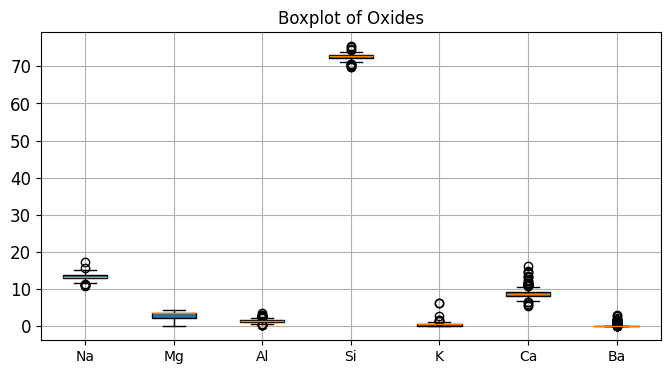

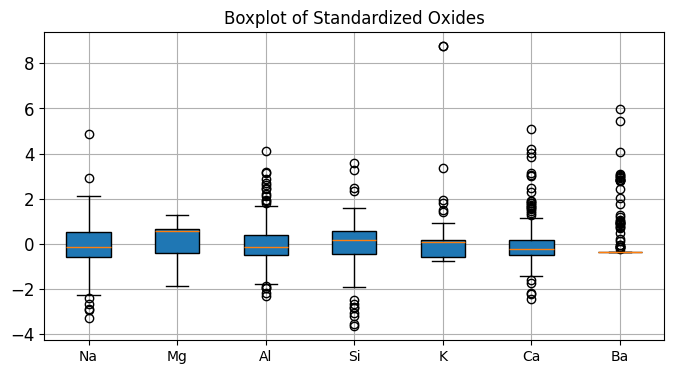

In [86]:
# Unstandardized
fig = plt.figure(figsize=(8, 4))
plt.title("Boxplot of Oxides")
plt.boxplot(df.iloc[:, 2:9], vert=True, patch_artist=True, tick_labels=df.columns[2:9]) # patch_artist=True zorgt voor kleur: "A patch is a 2D artist with a face color and an edge color."
plt.yticks(fontsize=12)
plt.grid()
plt.savefig("figures/boxplot_oxides.pdf")
plt.show()

# Standardized
fig = plt.figure(figsize=(8, 4))
plt.title("Boxplot of Standardized Oxides")
plt.boxplot(Xs.iloc[:, 1:8], vert=True, patch_artist=True, tick_labels=df.columns[2:9]) # patch_artist=True zorgt voor kleur: "A patch is a 2D artist with a face color and an edge color."
plt.yticks(fontsize=12)
plt.grid()
plt.savefig("figures/boxplot_standardized_oxides.pdf")
plt.show()

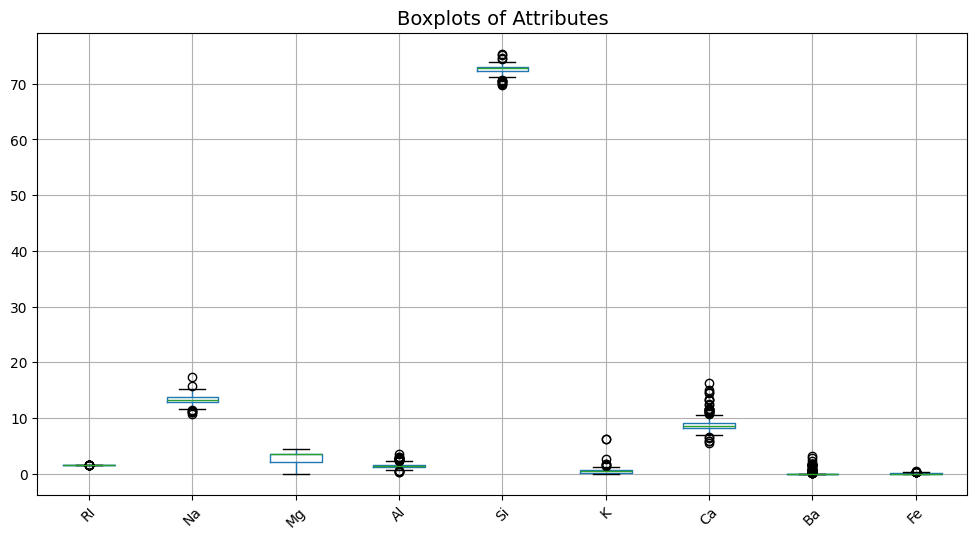

In [87]:
plt.figure(figsize=(12, 6))
X.boxplot(rot=45)
plt.title("Boxplots of Attributes", fontsize=14)
plt.show()

#### Boxplot of refractive index (RI)

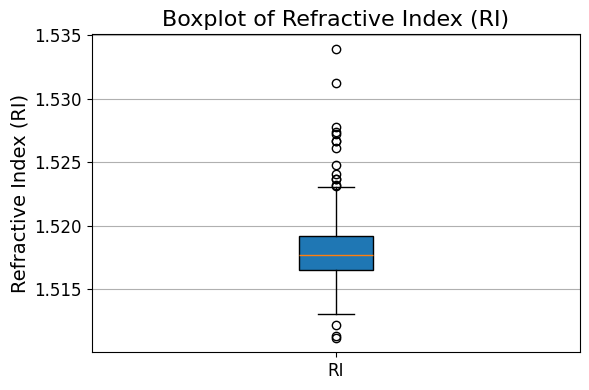

<Figure size 640x480 with 0 Axes>

In [88]:
fig = plt.figure(figsize=(6, 4))
plt.title("Boxplot of Refractive Index (RI)", fontsize=16)
plt.boxplot(df['RI'], vert=True, patch_artist=True) # patch_artist=True zorgt voor kleur: "A patch is a 2D artist with a face color and an edge color."
plt.ylabel("Refractive Index (RI)", fontsize=14)
plt.xticks([1], ['RI'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
plt.savefig("figures/boxplot_RI.pdf")

### Outlier detection (IQR and Z-score), counts per attribute and per class

In [89]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# boolean mask: True where value is an outlier (IQR rule)
outlier_mask_iqr = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))

# 1) Outlier counts per attribute (IQR method)
outlier_counts_by_attr = outlier_mask_iqr.sum().sort_values(ascending=False)
print("Outlier counts per attribute (IQR method):")
display(outlier_counts_by_attr)

# 2) Outlier counts per class: convert mask to int and group by df['Type']
#    (this avoids joining columns with duplicate names)
outlier_counts_by_class = outlier_mask_iqr.astype(int).groupby(df['Type']).sum().transpose()
outlier_counts_by_class.to_csv("figures/outlier_counts_by_class.csv")
print("Outlier counts per class (IQR method):")
display(outlier_counts_by_class)

# 3) Outlier percentage per class (per-attribute percentage of rows in that class that are outliers)
counts_per_class = df['Type'].value_counts().sort_index()
outlier_pct_by_class = (outlier_counts_by_class.div(counts_per_class, axis=1) * 100).round(2)
outlier_pct_by_class.to_csv("figures/outlier_pct_by_class.csv")
print("Outlier % per class (IQR method):")
display(outlier_pct_by_class)

# 4) Z-score method for comparison (|z| >= 3)
z_scores = (X - X.mean()) / X.std(ddof=1)
z_outliers = (z_scores.abs() >= 3).sum().sort_values(ascending=False)
print("Z-score outlier counts (|z| >= 3) per attribute:")
display(z_outliers)


Outlier counts per attribute (IQR method):


Ba    38
Ca    26
Al    18
RI    17
Si    12
Fe    12
Na     7
K      7
Mg     0
dtype: int64

Outlier counts per class (IQR method):


/var/folders/cc/4n08z0bx25j1czv79jvmgydc0000gn/T/ipykernel_1157/546185941.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outlier_counts_by_class = outlier_mask_iqr.astype(int).groupby(df['Type']).sum().transpose()


Type,BW-FP,BW-NFP,VW-FP,containers,tableware,headlamps
RI,3,9,0,1,1,3
Na,0,4,0,1,1,1
Mg,0,0,0,0,0,0
Al,4,0,0,3,1,10
Si,0,4,0,3,2,3
K,0,0,0,3,0,4
Ca,0,12,0,8,3,3
Ba,3,6,1,2,0,26
Fe,3,6,1,2,0,0


Outlier % per class (IQR method):


Type,BW-FP,BW-NFP,VW-FP,containers,tableware,headlamps
RI,4.29,11.84,0.00,7.69,11.11,10.34
Na,0.00,5.26,0.00,7.69,11.11,3.45
Mg,0.00,0.00,0.00,0.00,0.00,0.00
Al,5.71,0.00,0.00,23.08,11.11,34.48
Si,0.00,5.26,0.00,23.08,22.22,10.34
K,0.00,0.00,0.00,23.08,0.00,13.79
Ca,0.00,15.79,0.00,61.54,33.33,10.34
Ba,4.29,7.89,5.88,15.38,0.00,89.66
Fe,4.29,7.89,5.88,15.38,0.00,0.00


Z-score outlier counts (|z| >= 3) per attribute:


Ca    7
Ba    6
Si    6
RI    3
Al    3
K     3
Fe    3
Na    2
Mg    0
dtype: int64

### Distribution of the attributes

#### Histograms

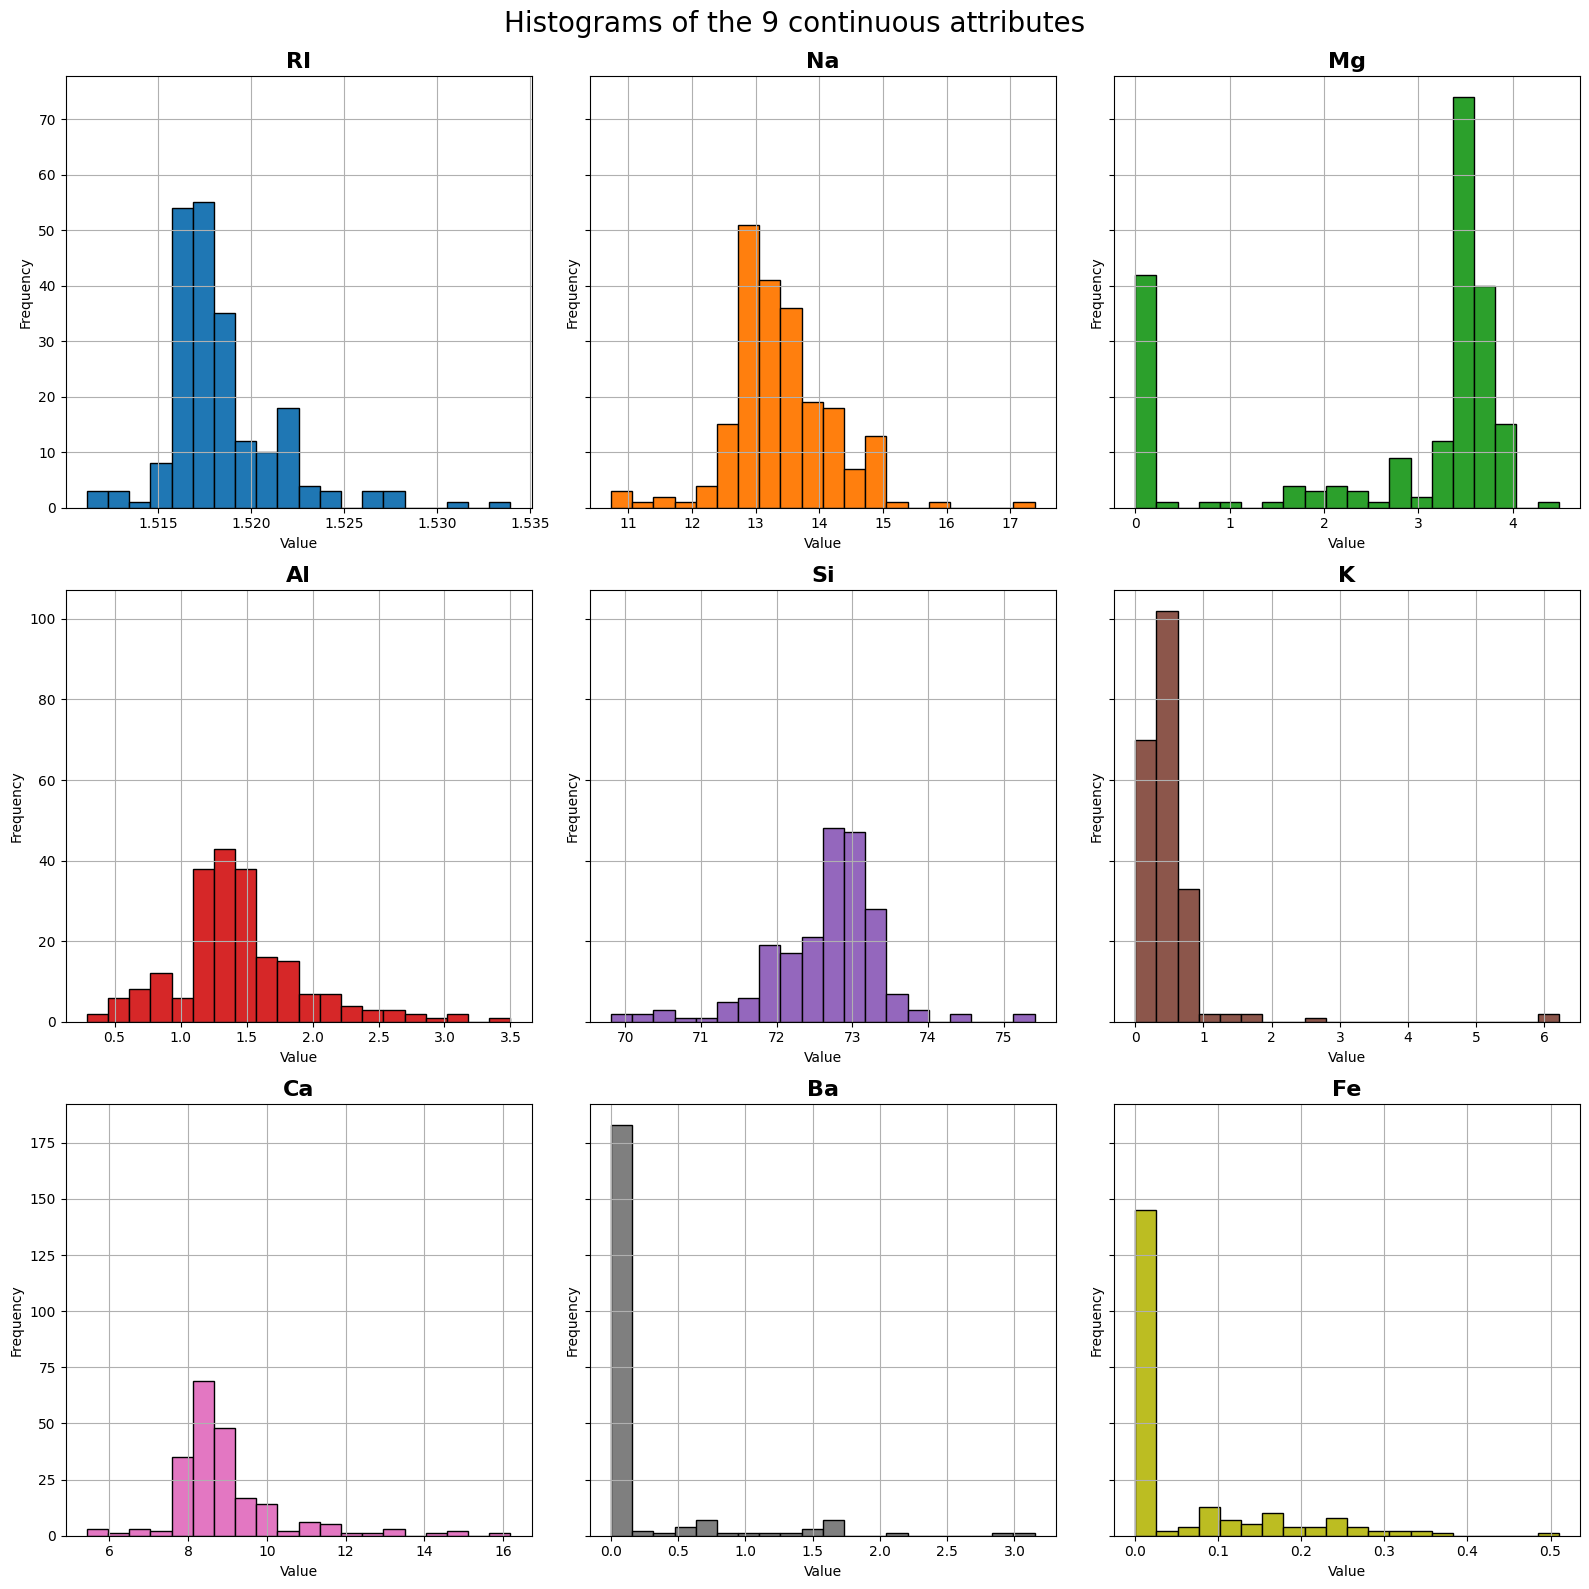

In [90]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16), sharey="row", sharex=None) # share y- (sharey) or x-axis (sharex) (True/'all', False/'none', 'row', 'col')
fig.suptitle("Histograms of the 9 continuous attributes", fontsize=20, y=0.99)

for j in range(9):
    ax = axs[j // 3, j % 3]
    ax.hist(df.iloc[:, j+1], color=f"C{j}", bins=20, edgecolor='black') 
    # -> f"C{j}" is a nice way to get different colors
    # -> a bin is an interval
    # -> dividing the values into bins (of equal size) is called 'binning'
    # -> don't forget edgecolor
    ax.grid()
    ax.set_title(df.columns[j+1], fontsize=16, fontweight='bold')
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("figures/histograms_chemical_elements.pdf")
plt.show()

#### Distribution of the type

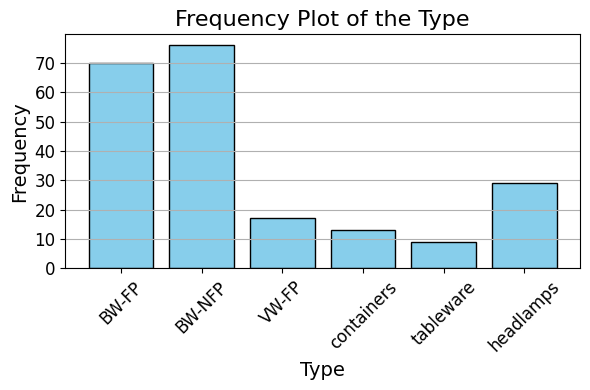

In [91]:
# Make a frequency plot of the target variable
fig = plt.figure(figsize=(6, 4))
plt.title("Frequency Plot of the Type", fontsize=16)
plt.bar(y.cat.codes.unique(), type_counts, color="skyblue", edgecolor='black')
plt.xlabel("Type", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Rename x ticks
# so that the class names are converted to numbers
# plt.xticks(ticks=range(len(y_df.cat.codes.unique())), labels=y_df.cat.codes.unique(), fontsize=12)

plt.xticks(ticks=range(len(y.cat.categories)), labels=y.cat.categories, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("figures/frequency_plot_type.pdf")
plt.show()

### Correlation between attributes

#### Correlations

          RI        Na        Mg        Al        Si         K        Ca  \
RI  1.000000 -0.191885 -0.122274 -0.407326 -0.542052 -0.289833  0.810403   
Na -0.191885  1.000000 -0.273732  0.156794 -0.069809 -0.266087 -0.275442   
Mg -0.122274 -0.273732  1.000000 -0.481799 -0.165927  0.005396 -0.443750   
Al -0.407326  0.156794 -0.481799  1.000000 -0.005524  0.325958 -0.259592   
Si -0.542052 -0.069809 -0.165927 -0.005524  1.000000 -0.193331 -0.208732   
K  -0.289833 -0.266087  0.005396  0.325958 -0.193331  1.000000 -0.317836   
Ca  0.810403 -0.275442 -0.443750 -0.259592 -0.208732 -0.317836  1.000000   
Ba -0.000386  0.326603 -0.492262  0.479404 -0.102151 -0.042618 -0.112841   
Fe  0.143010 -0.241346  0.083060 -0.074402 -0.094201 -0.007719  0.124968   

          Ba        Fe  
RI -0.000386  0.143010  
Na  0.326603 -0.241346  
Mg -0.492262  0.083060  
Al  0.479404 -0.074402  
Si -0.102151 -0.094201  
K  -0.042618 -0.007719  
Ca -0.112841  0.124968  
Ba  1.000000 -0.058692  
Fe -0.058692  

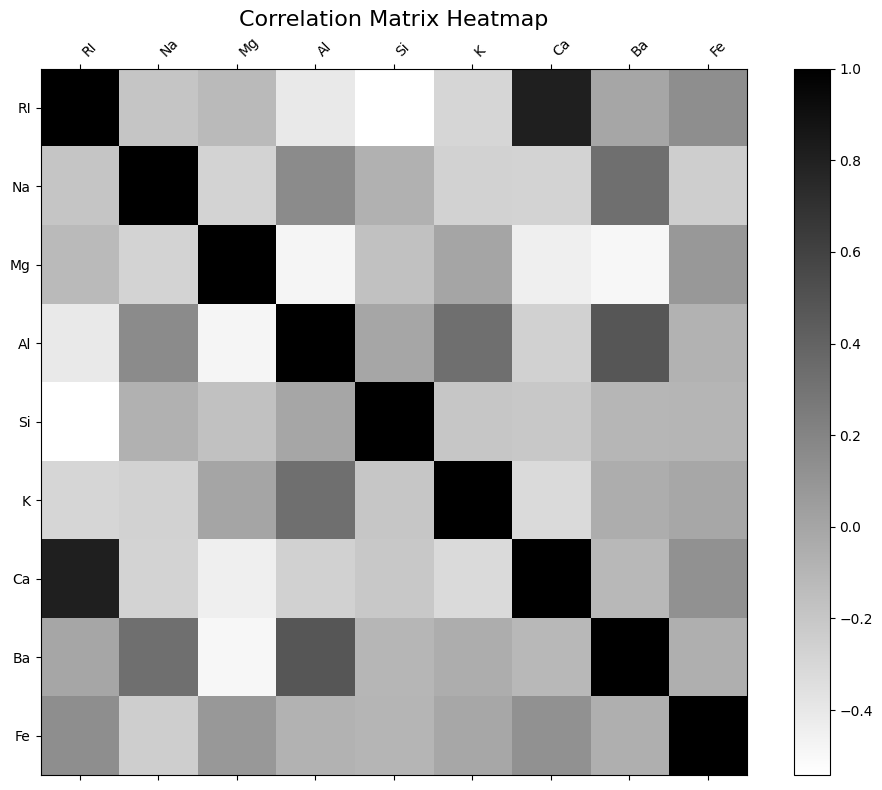

In [92]:
# Correlation (standardized covariance) matrix
corr_matrix = X.corr()
print(corr_matrix)

# Visualize the correlation matrix using a heatmap
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr_matrix, cmap='gray_r')
fig.colorbar(cax)
ticks = np.arange(0, len(X.columns), 1) # Corrected to use X.columns, X_df is not defined
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns, rotation=45, ha='left')
ax.set_yticklabels(X.columns)
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.tight_layout()
plt.savefig("figures/correlation_matrix.pdf")
plt.show()

#### Individual correlations

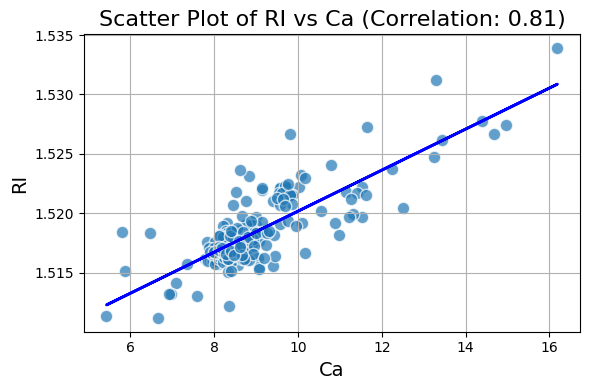

In [93]:
def correlation_plot(x, y, x_label, y_label, filename, save=False):
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.7, edgecolors='w', s=80)
    # Add a regression line
    slope, intercept = np.polyfit(x, y, 1)
    plt.plot(x, slope*x + intercept, color='blue', linewidth=2)
    plt.title(f'Scatter Plot of {y_label} vs {x_label} (Correlation: {corr_matrix.loc[attr1, attr2]:.2f})', fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(f'figures/{filename}.pdf')   
    plt.show()

attr1 = 'Ca'
attr2 = 'RI'
correlation_plot(X[attr1], X[attr2], attr1, attr2, f'scatter_{attr2}_vs_{attr1}', True)

#### Mix scatter plots



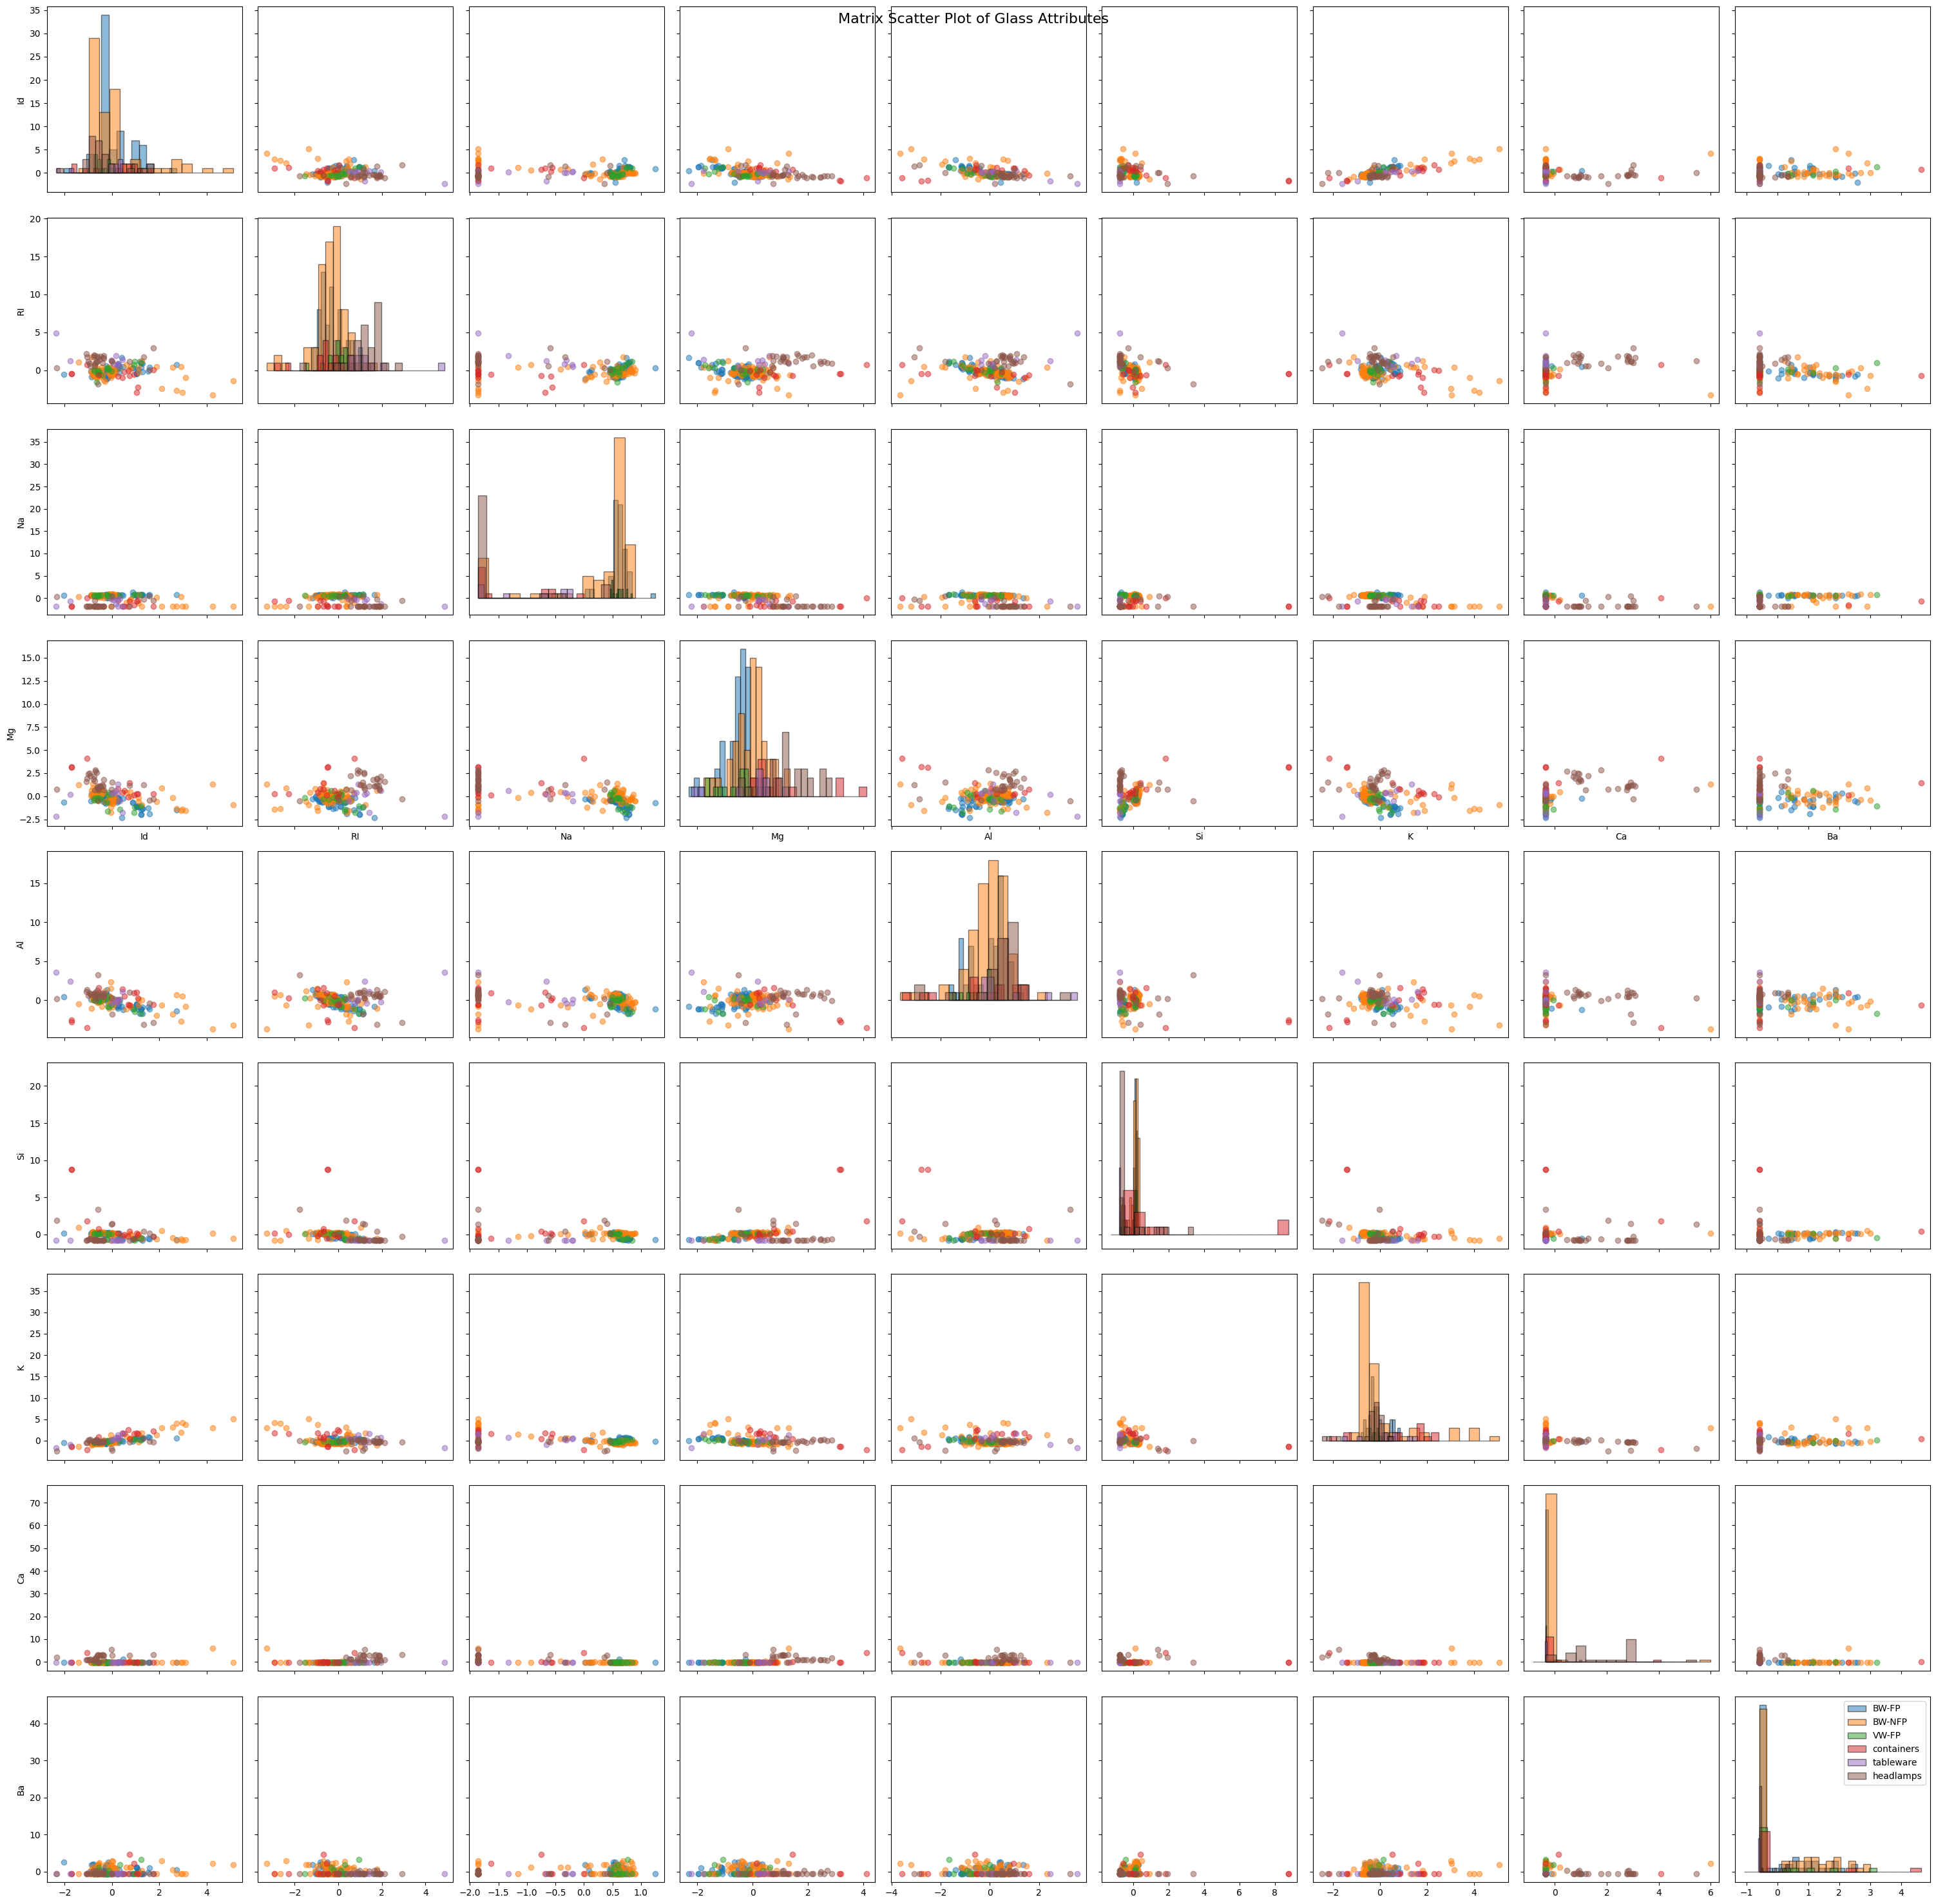

In [94]:
fig, axs = plt.subplots(9, 9, figsize=(30, 30), sharex='col', sharey='row')

list_of_types = df["Type"].unique() # get unique glass types

fig.suptitle("Matrix Scatter Plot of Glass Attributes", fontsize=16) # overall title

# Loop over i (rows) and j (columns)
for i in range(9):
    for j in range(9):

        # loop through each type
        for (type_index, type) in enumerate(list_of_types): 

            # Filter the dataframe for the current type
            subset = df.query(f'Type == "{type}"')

            # Standardized values
            subset = (subset.iloc[:, 1:10] - X.mean(axis=0)) / X.std(axis=0, ddof=1)

            if i == j:
                # Plot the histogram on the diagonal
                axs[i, j].hist(
                    subset.iloc[:, j], # values for the $j$'th attribute
                    label=type, alpha=0.5, color=f"C{type_index}", bins=15, edgecolor='black'
                )
            
            else:
                # Plot the scatter plot for attribute pair (if not on the diagonal)
                axs[i, j].scatter(
                    x=subset.iloc[:, j],        # x-values for the $j$'th attribute
                    y=subset.iloc[:, i],        # y-values for the $i$'th attribute
                    label=type, alpha=0.5
                )

        if j == 0: # Set the y-label for the first column!!
            axs[i, j].set_ylabel(df.columns[i])
        if i == 3: # Set the x-label for the last row!!
            axs[i, j].set_xlabel(df.columns[j])

# Add the legend to the last subplot only!!
axs[8, 8].legend(loc='upper right')
plt.tight_layout()
plt.show()

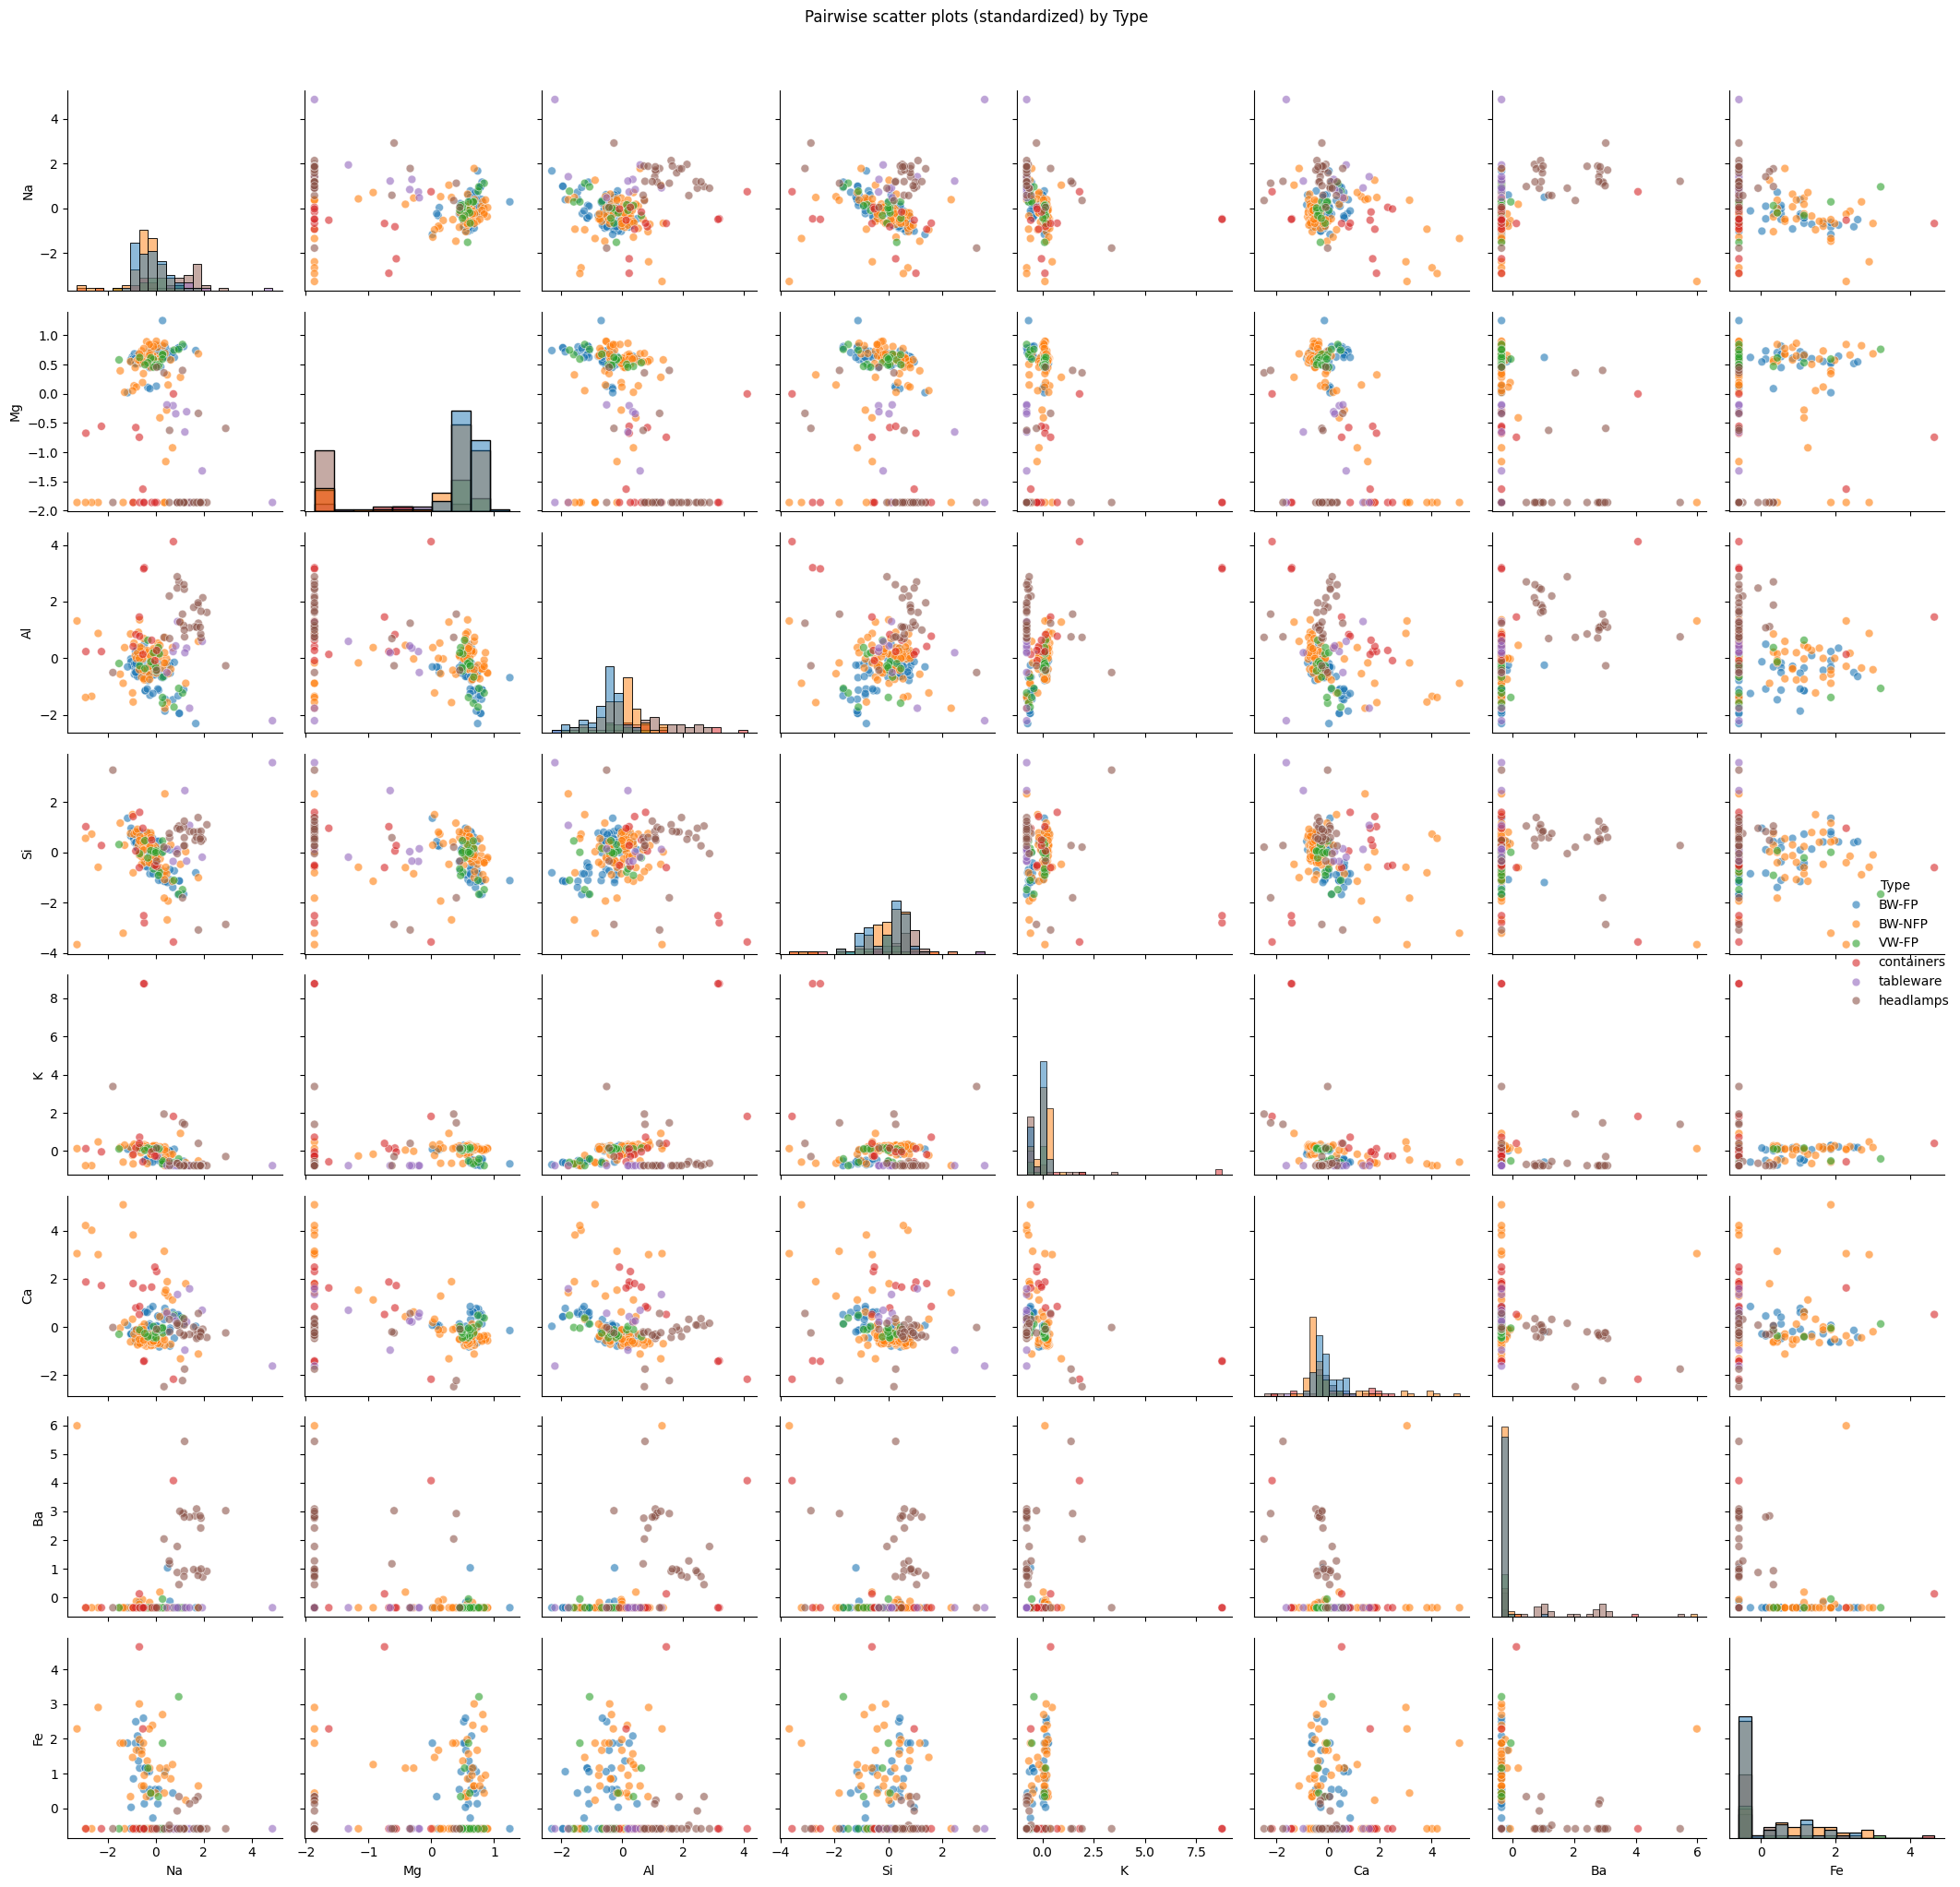

In [95]:
# Pairwise scatter/hist by class using standardized features
Xes_df = pd.DataFrame(Xes, columns=Xe.columns, index=X.index)

pca_plot_df = Xes_df.copy()
pca_plot_df['Type'] = df['Type'].values

# using the chemical element attributes (8 cols, consistent with Xes_df)
attrs = Xe.columns.tolist()

subset_attrs = attrs  # or attrs[:6] for a smaller subset
sns.pairplot(
    pca_plot_df,
    vars=subset_attrs,
    hue='Type',
    diag_kind='hist',
    corner=False,
    plot_kws={'alpha': 0.6, 's': 40}
)
plt.suptitle("Pairwise scatter plots (standardized) by Type", y=1.02)
plt.tight_layout()
plt.savefig("figures/pairwise_standardized_by_type.pdf")
plt.show()


## 4. Principal Component Analysis (PCA)

**!! Will we do PCA on all 9 numerical attributes or only on the oxides? !!**

- All numerical attributes: 
    -   Use `Xm` for the centered dataframe
    -   Use `Xs` for the standardized dataframe
- Only oxides:
    -   Use `Xem` for the centered dataframe
    -   Use `Xes` for the standardized dataframe

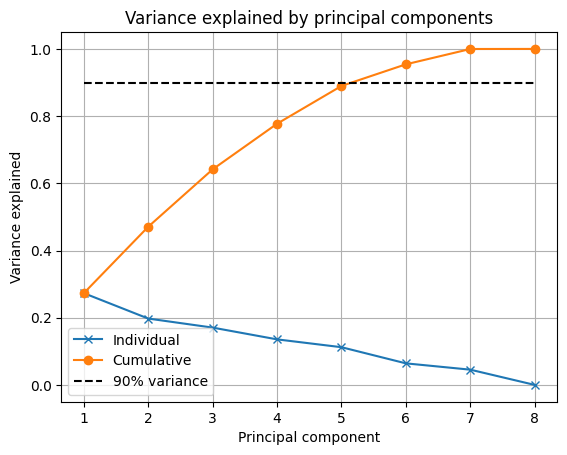

In [96]:
# Create PCA object
pca = PCA()

## Fit PCA to the (centered) data
## This centering is done automatically by sklearn PCA!
# pca.fit(X)

# Fit PCA to the standardized data
pca.fit(Xes)

# V = P is the loading matrix
# So B = XV = XP

# Get principal components
Vt = pca.components_    # each row is a principal component
V = Vt.T                # each column is a principal component

# Explained variances per component
rho = pca.explained_variance_ratio_

# 90% threshold for variance explained
threshold = 0.9

# Plot variance explained
plt.figure()
plt.plot(range(1, len(rho) + 1), rho, "x-")
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-")
plt.plot([1, len(rho)], [threshold, threshold], "k--")
plt.title("Variance explained by principal components")
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.legend(["Individual", "Cumulative", f"{threshold*100:.0f}% variance"])
plt.grid()
plt.show()

### Explained variance summary

In [97]:
rho = pca.explained_variance_ratio_
cumvar = np.cumsum(rho)
pca_summary = pd.DataFrame({'PC': np.arange(1, len(rho)+1), 'explained_var': rho, 'cumulative_var': cumvar})
pca_summary.round(4).to_csv("figures/pca_explained_variance.csv", index=False)
display(pca_summary.round(4))
print(f"Number of PCs to reach 90% variance: {np.searchsorted(cumvar, 0.90) + 1}")

,PC,explained_var,cumulative_var
0,1,0.2733,0.2733
1,2,0.1977,0.4709
2,3,0.1708,0.6417
3,4,0.1357,0.7774
4,5,0.1124,0.8898
5,6,0.0644,0.9542
6,7,0.0456,0.9998
7,8,0.0002,1.0000


Number of PCs to reach 90% variance: 6


In [98]:
# Project X to the subspace
B = pca.transform(Xes) # B = (Xs @ V).to_numpy()

# Withheld number of components
M = 5

# Print the rotations
print("Rotations (Principal Axes):")
for i in range(M):
    print(f"PC {i+1}: {V[:, i]}")

Rotations (Principal Axes):
PC 1: [ 0.37840266 -0.49734843  0.52120149  0.02189015  0.06315266 -0.10713827
  0.53648121 -0.18451784]
PC 2: [ 0.03593813 -0.4018974  -0.23024259  0.0154208  -0.53880408  0.69198612
  0.06259528  0.10423377]
PC 3: [-0.47711085 -0.19222531  0.26350271 -0.39096539  0.48863986  0.3227271
  0.06531347  0.40735674]
PC 4: [-0.41768157 -0.26734983  0.16359681  0.82927746  0.10487427  0.00317247
 -0.16695209 -0.02682316]
PC 5: [ 0.10371558  0.12181725  0.05628556  0.19298642 -0.2766782  -0.28521853
  0.2439764   0.84650275]


/var/folders/cc/4n08z0bx25j1czv79jvmgydc0000gn/T/ipykernel_1157/1722106794.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  centroids = pc_df.groupby('Type')[['PC1','PC2']].mean()


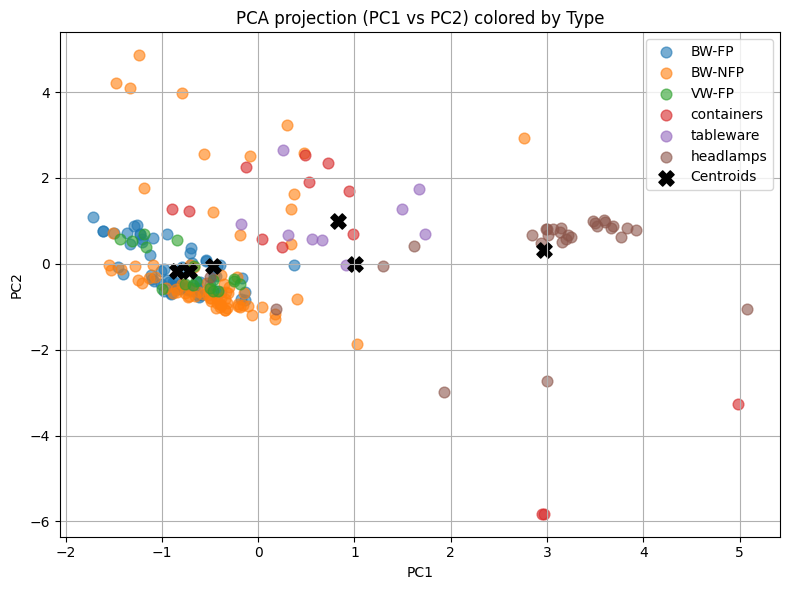

In [99]:
# PCA scatter in PC1-PC2 space colored by Type, added centroids 
pc_df = pd.DataFrame(B[:, :3], columns=['PC1','PC2','PC3'])  # keep first 3
pc_df['Type'] = df['Type'].values

plt.figure(figsize=(8, 6))
types = pc_df['Type'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(types)))
for t, c in zip(types, colors):
    sub = pc_df[pc_df['Type'] == t]
    plt.scatter(sub['PC1'], sub['PC2'], label=t, alpha=0.6, s=60)

# centroids
centroids = pc_df.groupby('Type')[['PC1','PC2']].mean()
plt.scatter(centroids['PC1'], centroids['PC2'], marker='X', s=120, c='k', label='Centroids')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA projection (PC1 vs PC2) colored by Type')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("figures/pca_pc1_pc2_by_type.pdf")
plt.show()


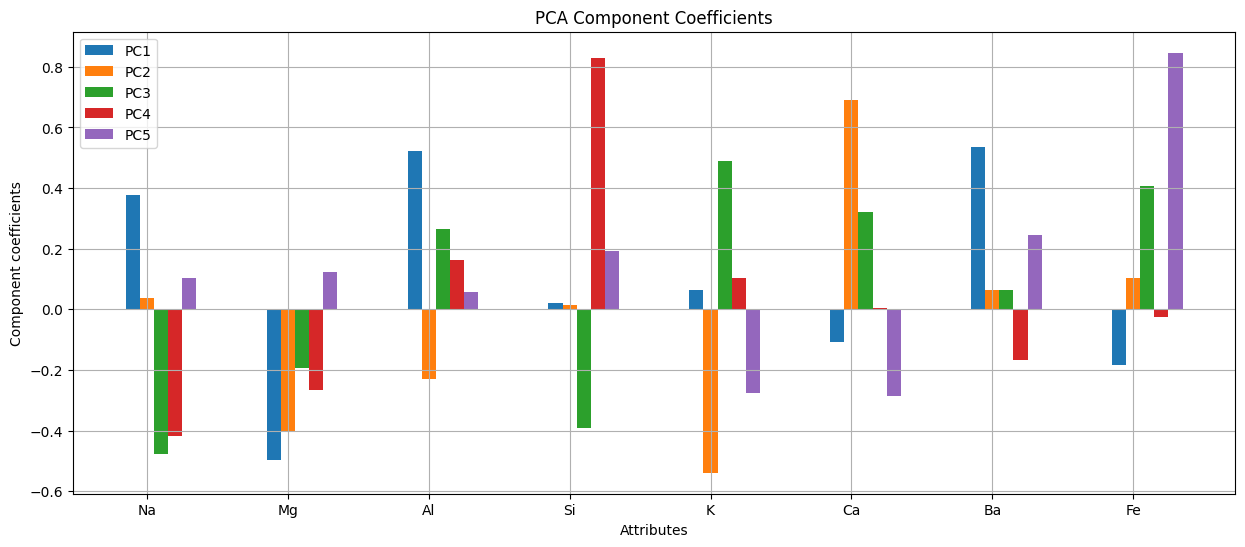

In [100]:
bw = 0.1 # bar width
r = np.arange(1, Xes.shape[1] + 1) # the x locations for the groups

fig = plt.figure(figsize=(15, 6))
plt.title("PCA Component Coefficients")
for i, pc in enumerate(V[:, :M].T):
    plt.bar(r + i * bw, pc, width=bw, label=f"PC{i+1}")
plt.xticks(r + bw, Xes.columns)
plt.xlabel("Attributes")
plt.ylabel("Component coefficients")
plt.legend()
plt.grid()
plt.show()

Plot attribute coefficients in principal component space

### PCA biplot + table of top-loading attributes per PC

Top 3 attributes per PC (by absolute loading):
PC1: ['Ba', 'Al', 'Mg']
PC2: ['Ca', 'K', 'Mg']
PC3: ['K', 'Na', 'Fe']


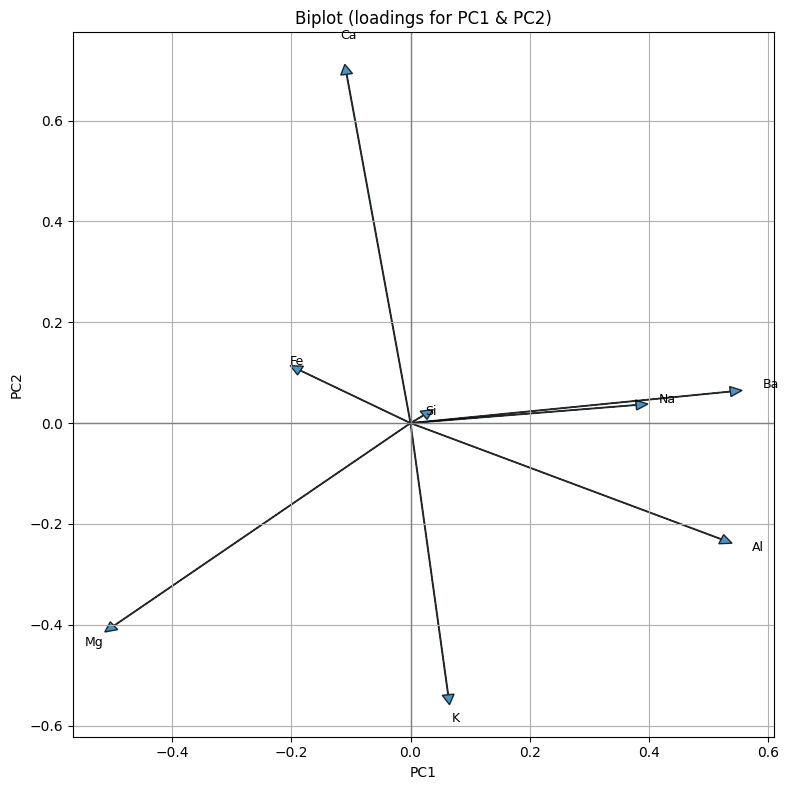

In [101]:
V = V  # principal axes
pc_loadings = pd.DataFrame(V, index=Xes.columns, columns=[f'PC{i+1}' for i in range(V.shape[1])])
pc_loadings_abs = pc_loadings.abs()

# for reporting: top 3 attributes (by absolute loading) per PC1..PC3
top_loadings = {}
for pc in ['PC1','PC2','PC3']:
    top_loadings[pc] = pc_loadings_abs[pc].sort_values(ascending=False).head(3).index.tolist()
print("Top 3 attributes per PC (by absolute loading):")
for k,v in top_loadings.items():
    print(f"{k}: {v}")

pc_loadings.round(3).to_csv("figures/pca_loadings.csv")

# biplot (PC1 vs PC2) arrows
plt.figure(figsize=(8, 8))
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
for i, attr in enumerate(pc_loadings.index):
    plt.arrow(0, 0, pc_loadings.loc[attr, 'PC1'], pc_loadings.loc[attr, 'PC2'], 
              head_width=0.02, head_length=0.02, linewidth=1, alpha=0.8)
    plt.text(pc_loadings.loc[attr, 'PC1']*1.1, pc_loadings.loc[attr, 'PC2']*1.1, attr, fontsize=9)

plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Biplot (loadings for PC1 & PC2)')
plt.grid()
plt.tight_layout()
plt.savefig("figures/pca_biplot_pc1_pc2.pdf")
plt.show()


### Baseline classification experiments (train/test) + cross-validation + confusion matrix

RandomForest test accuracy: 0.6744
Classification report (RandomForest):
              precision    recall  f1-score   support

       BW-FP       0.65      0.79      0.71        14
      BW-NFP       0.67      0.67      0.67        15
       VW-FP       0.00      0.00      0.00         3
  containers       1.00      0.67      0.80         3
   headlamps       0.83      0.83      0.83         6
   tableware       0.50      0.50      0.50         2

    accuracy                           0.67        43
   macro avg       0.61      0.58      0.58        43
weighted avg       0.65      0.67      0.66        43



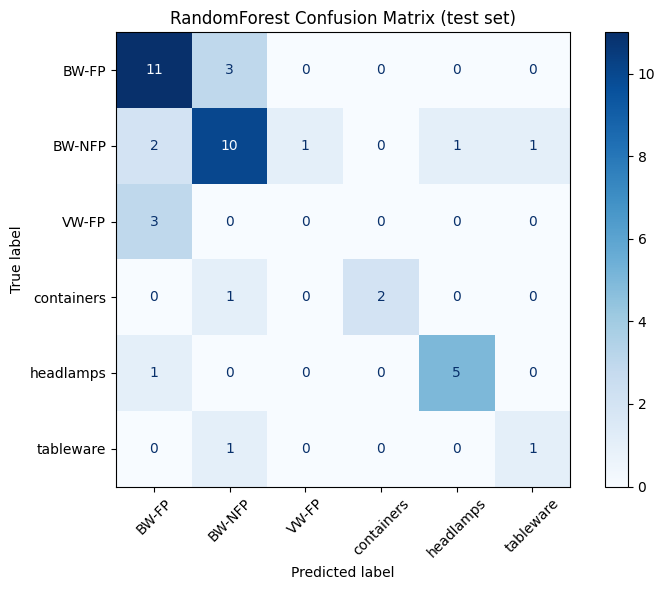

RandomForest 5-fold CV accuracy (mean ± std): 0.7475 ± 0.0286
Logistic Regression test accuracy: 0.6512
Classification report (LogisticRegression):
              precision    recall  f1-score   support

       BW-FP       0.67      0.71      0.69        14
      BW-NFP       0.59      0.67      0.62        15
       VW-FP       0.00      0.00      0.00         3
  containers       1.00      0.67      0.80         3
   headlamps       0.83      0.83      0.83         6
   tableware       0.50      0.50      0.50         2

    accuracy                           0.65        43
   macro avg       0.60      0.56      0.57        43
weighted avg       0.63      0.65      0.64        43



/Users/armandomijares/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [102]:
# prepare X (standardized) and y numeric
X_final = Xes.copy()  # standardized features (DataFrame)
y_final = y_num       # numeric labels created earlier with LabelEncoder

# train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, stratify=y_final, random_state=42)

# rf baseline
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("RandomForest test accuracy:", round(acc_rf, 4))
print("Classification report (RandomForest):")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("RandomForest Confusion Matrix (test set)")
plt.tight_layout()
plt.savefig("figures/confusion_matrix_rf_test.pdf")
plt.show()

# cross-validation accuracy (5-fold stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X_final, y_final, cv=cv, scoring='accuracy')
print("RandomForest 5-fold CV accuracy (mean ± std):", round(cv_scores.mean(),4), "±", round(cv_scores.std(),4))

# log reg
pipe = Pipeline([('clf', LogisticRegression(max_iter=500, multi_class='auto', solver='lbfgs'))])
pipe.fit(X_train, y_train)
print("Logistic Regression test accuracy:", round(pipe.score(X_test, y_test),4))
print("Classification report (LogisticRegression):")
print(classification_report(y_test, pipe.predict(X_test), target_names=label_encoder.classes_))


#### Feature importance plot from RandomForest

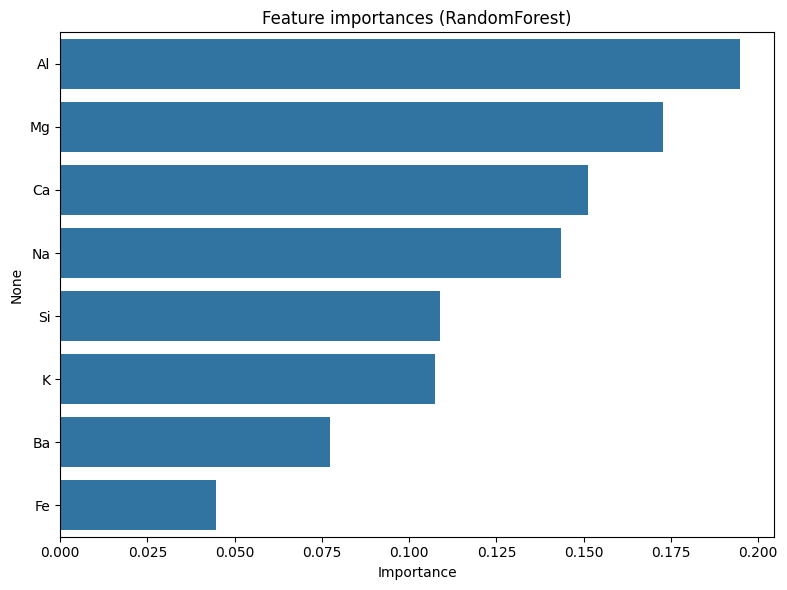

Top features:
 Al    0.194740
Mg    0.172657
Ca    0.151301
Na    0.143536
Si    0.108710
K     0.107272
Ba    0.077255
Fe    0.044529
dtype: float64


In [103]:
importances = pd.Series(rf.feature_importances_, index=X_final.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature importances (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("figures/feature_importances_rf.pdf")
plt.show()
importances.to_csv("figures/feature_importances_rf.csv")
print("Top features:\n", importances.head(10))

### PCA + classifier experiment: classification after PCA dimensionality reduction

In [104]:
# Pipeline: PCA (n components) + classifier to test effect of dimension reduction 
from sklearn.decomposition import PCA as SKPCA

for n_comp in [2, 3, 5]:
    pipe = Pipeline([
        ('pca', SKPCA(n_components=n_comp, random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
    ])
    scores = cross_val_score(pipe, X_final, y_final, cv=cv, scoring='accuracy')
    print(f"PCA({n_comp}) + RF: CV accuracy = {scores.mean():.4f} ± {scores.std():.4f}")


PCA(2) + RF: CV accuracy = 0.5650 ± 0.0713
PCA(3) + RF: CV accuracy = 0.6495 ± 0.0571
PCA(5) + RF: CV accuracy = 0.6775 ± 0.0345
